In [1]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt
import transformers

from collections import defaultdict #, Counter
from transformers import AutoModelForMaskedLM, AutoTokenizer

from operator import mul
from functools import reduce


device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

MODEL_NAME = 'xlm-roberta-large'
MASK_TOKEN = '<mask>'
PAD_TOKEN = '<pad>'
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
device = torch.device('cuda:0')
model.to(device)
reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}

In [2]:
# let's check the number of tokens in our keywords
keywords = ['anything', 'anybody']
keywords2tokens = dict()

for keyword in keywords:
    tokens = tokenizer.tokenize(keyword)
    keywords2tokens[keyword] = tokens
    print(len(tokens), tokens)


1 ['▁anything']
2 ['▁any', 'body']


In [3]:
# parse, mask, tokenize

subj_dict = dict()
verb_dict = dict()

def mask_sent(sent, kword):
    return [BOS_TOKEN,] + tokenizer.tokenize( 
        sent.replace(kword, f'{MASK_TOKEN} '*len(keywords2tokens[kword])).replace('  ',' ') 
    ) + [EOS_TOKEN,]

tokenized_array = []
metadata_array = []

for idx, line in enumerate(open('en_test_sentences.tsv', encoding='utf-8')):
    chunks = line.strip().split()
    tchunks = line.strip().split('\t')

    if chunks[-1]=='thing':
        kwords = ('anything','anything','anything','anything')
    else:
        kwords = ('anybody','anybody','anybody','anybody')
    
    subj_id = int(chunks[-3])
    subject = chunks[1]
    subj_dict[subj_id] = subject
    verb_id = int(chunks[-2])
    verb1 = chunks[2]
    verb2 = chunks[8]
    verb_dict[verb_id] = (verb1, verb2)
    
    for tidx, (cl,kword) in enumerate( zip( ('aff', 'neg', 'many', 'few'), kwords ) ):
        mt_sent = mask_sent(tchunks[tidx], kword)
        tokenized_array.append( mt_sent )
        metadata_array.append( 
            (
                (cl, subj_id, verb_id, kword, chunks[-1]),
                (tchunks[tidx], mt_sent)
            )
        )


In [4]:
def assess_batch(batch, metas):
    batch_input_ids = []
    batch_segment_ids = []
    
    mask_positions = []
    mask_lens = []

    max_len = max(map(len,batch))
    
    for s in batch:
        mask_positions.append( s.index(MASK_TOKEN) )
        mask_lens.append( s.count(MASK_TOKEN) )
        
        input_ids = tokenizer.convert_tokens_to_ids(s + [PAD_TOKEN,]*(max_len-len(s)))
        batch_input_ids.append( input_ids )
        batch_segment_ids.append( [0] * len(input_ids) )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    return [
        reduce(mul, [pr[pos+t_pos][tokenizer.vocab[tok]].cpu().detach().numpy() \
            for t_pos, tok in enumerate(keywords2tokens[meta[0][3]]) ], 1. ) \
                for pr, pos, meta in zip(probs, mask_positions, metas)
    ]
        
assess_batch(tokenized_array[128*4:130*4], metadata_array[126*4:130*4])

[9.961490832210984e-06,
 7.89411278674379e-05,
 2.747809446645988e-07,
 1.857751158240717e-06,
 0.0003162752836942673,
 0.1610874980688095,
 1.661290843912866e-05,
 0.00010101577208843082]

In [7]:
# assess all the sentences

BATCH_SIZE = 40

scores = []
for idx in range(0, len(tokenized_array), BATCH_SIZE):
    if not idx%200: print(f'{idx/(len(tokenized_array)):.2%}')
    scores.extend( assess_batch(tokenized_array[idx:idx+BATCH_SIZE], metadata_array[idx:idx+BATCH_SIZE]) )

0.00%
0.50%
1.00%
1.50%
2.00%
2.50%
3.00%
3.50%
4.00%
4.50%
5.00%
5.50%
6.00%
6.50%
7.00%
7.50%
8.00%
8.50%
9.00%
9.50%
10.00%
10.50%
11.00%
11.50%
12.00%
12.50%
13.00%
13.50%
14.00%
14.50%
15.00%
15.50%
16.00%
16.50%
17.00%
17.50%
18.00%
18.50%
19.00%
19.50%
20.00%
20.50%
21.00%
21.50%
22.00%
22.50%
23.00%
23.50%
24.00%
24.50%
25.00%
25.50%
26.00%
26.50%
27.00%
27.50%
28.00%
28.50%
29.00%
29.50%
30.00%
30.50%
31.00%
31.50%
32.00%
32.50%
33.00%
33.50%
34.00%
34.50%
35.00%
35.50%
36.00%
36.50%
37.00%
37.50%
38.00%
38.50%
39.00%
39.50%
40.00%
40.50%
41.00%
41.50%
42.00%
42.50%
43.00%
43.50%
44.00%
44.50%
45.00%
45.50%
46.00%
46.50%
47.00%
47.50%
48.00%
48.50%
49.00%
49.50%
50.00%
50.50%
51.00%
51.50%
52.00%
52.50%
53.00%
53.50%
54.00%
54.50%
55.00%
55.50%
56.00%
56.50%
57.00%
57.50%
58.00%
58.50%
59.00%
59.50%
60.00%
60.50%
61.00%
61.50%
62.00%
62.50%
63.00%
63.50%
64.00%
64.50%
65.00%
65.50%
66.00%
66.50%
67.00%
67.50%
68.00%
68.50%
69.00%
69.50%
70.00%
70.50%
71.00%
71.50%
72.00%
72.50

In [8]:
len(scores)

40000

In [9]:
# reshape scores
stats = defaultdict(lambda:defaultdict(lambda:defaultdict(float)))

for score, meta in zip(scores, metadata_array):
    if meta[0][0]=='aff':
        handle = (meta[0][4], 'aff>neg')
        k_idx = 0
    if meta[0][0]=='neg':
        handle = (meta[0][4], 'aff>neg')
        k_idx = 1
    if meta[0][0]=='many':
        handle = (meta[0][4], 'many>few')
        k_idx = 0
    if meta[0][0]=='few':
        handle = (meta[0][4], 'many>few')
        k_idx = 1
    stats[handle][(meta[0][1], meta[0][2])][k_idx] = score
    handle = ('both', handle[1])
    stats[handle][(meta[0][1], meta[0][2])][k_idx] += score


In [10]:
for handle in sorted(stats):
    print(handle, 
          f'  {np.count_nonzero(list(map(lambda x:x[0]>x[1], stats[handle].values())))/len(stats[handle].values()):0.3%}')

('body', 'aff>neg')   0.509%
('body', 'many>few')   37.861%
('both', 'aff>neg')   0.350%
('both', 'many>few')   25.266%
('thing', 'aff>neg')   0.351%
('thing', 'many>few')   25.221%


(array([3.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 6.000e+00, 2.000e+00,
        8.000e+00, 2.400e+01, 2.560e+02, 8.516e+03]),
 array([-0.14569315, -0.12968842, -0.1136837 , -0.09767897, -0.08167424,
        -0.06566952, -0.04966479, -0.03366006, -0.01765534, -0.00165061,
         0.01435412]),
 <BarContainer object of 10 artists>)

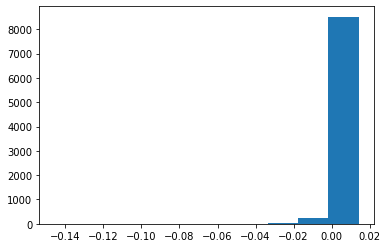

In [11]:
plt.hist(list(map(lambda x:x[0]-x[1],stats[('thing', 'many>few')].values())))

(array([3.000e+00, 7.000e+00, 1.700e+01, 3.800e+01, 9.200e+01, 1.860e+02,
        2.790e+02, 4.590e+02, 1.143e+03, 6.598e+03]),
 array([-0.89432022, -0.8029981 , -0.71167598, -0.62035386, -0.52903174,
        -0.43770962, -0.3463875 , -0.25506538, -0.16374326, -0.07242114,
         0.01890098]),
 <BarContainer object of 10 artists>)

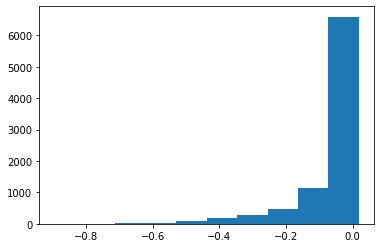

In [12]:
plt.hist(list(map(lambda x:x[0]-x[1],stats[('thing', 'aff>neg')].values())))